In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

print("NumPy version:", np.__version__)


NumPy version: 2.4.1


In [3]:
# main reference used: https://www.youtube.com/watch?v=w8yWXqWQYmU

In [20]:
def load_mnist_images(path):
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    return data.reshape(-1, 28*28)

def load_mnist_labels(path):
    with open(path, 'rb') as f:
        return np.frombuffer(f.read(), dtype=np.uint8, offset=8)

# Load data
X_train = load_mnist_images("./data/mnist/train-images.idx3-ubyte")
y_train = load_mnist_labels("./data/mnist/train-labels.idx1-ubyte")

X_test = load_mnist_images("./data/mnist/t10k-images.idx3-ubyte")
y_test = load_mnist_labels("./data/mnist/t10k-labels.idx1-ubyte")

# Ensure correct shapes before stacking
X_train = X_train.reshape(X_train.shape[0], 784)
X_test  = X_test.reshape(X_test.shape[0], 784)

y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)

# Normalize
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0


train_data = np.hstack([y_train, X_train])
test_data  = np.hstack([y_test,  X_test])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(60000, 784) (60000, 1)
(10000, 784) (10000, 1)


Train Data (numpy array check)): (69000, 785)
Test Data (numpy array check)): (1000, 785)
Label check: 4.0


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

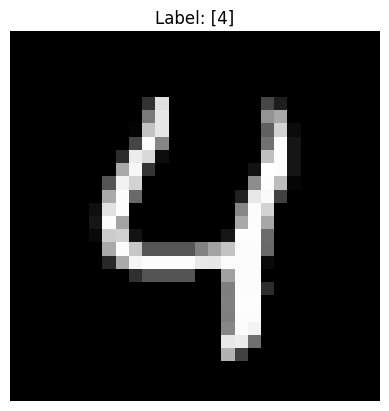

In [21]:
# Combine labels + pixels like the CSV format
train_data = np.hstack([
    y_train.reshape(-1, 1),   # first column = label
    X_train                   # remaining 784 columns = pixels
])

test_data = np.hstack([
    y_test.reshape(-1, 1),   # first column = label
    X_test                  # remaining 784 columns = pixels
])

df1 = pd.DataFrame(train_data)
df2 = pd.DataFrame(test_data)

data_train = df1.to_numpy()
data_dev = df2.to_numpy()

data_dev_keep = data_dev[:1000]
data_dev_move = data_dev[1000:]

data_train = np.vstack([data_train, data_dev_move])
data_dev = data_dev_keep

print("Train Data (numpy array check)):",data_train.shape)
print("Test Data (numpy array check)):",data_dev.shape)

idx = 4

print("Label check:", data_dev[idx,0])

plt.imshow(X_test[idx].reshape(28, 28), cmap="grey")
plt.title(f"Label: {y_test[idx]}")
plt.axis("off")

In [22]:
m, n = data_dev.shape[0] + data_train.shape[0] ,data_dev.shape[1] 
print(m,n)

70000 785


In [23]:
np.random.shuffle(data_dev)
data_dev = data_dev.T
X_dev = data_dev[1:n]
Y_dev = data_dev[0]

np.random.shuffle(data_train)
data_train = data_train.T
X_train = data_train[1:n]
Y_train = data_train[0]

Y_train = Y_train.astype(int)
Y_dev   = Y_dev.astype(int)

print("Test dims, imgs and labels:", X_dev.shape, Y_dev.shape)
print("Train dims:", X_train.shape, Y_train.shape)


Test dims, imgs and labels: (784, 1000) (1000,)
Train dims: (784, 69000) (69000,)


In [24]:
X_train[:,0].shape

(784,)

In [25]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [26]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [27]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[7 2 3 ... 7 2 2] [2 5 1 ... 2 5 4]
0.0969855072463768
Iteration:  10
[7 6 3 ... 7 2 0] [2 5 1 ... 2 5 4]
0.18521739130434783
Iteration:  20
[7 6 3 ... 7 0 0] [2 5 1 ... 2 5 4]
0.2446086956521739
Iteration:  30
[2 6 3 ... 6 0 0] [2 5 1 ... 2 5 4]
0.29491304347826086
Iteration:  40
[2 6 1 ... 6 0 0] [2 5 1 ... 2 5 4]
0.35589855072463766
Iteration:  50
[2 6 1 ... 2 0 0] [2 5 1 ... 2 5 4]
0.39953623188405796
Iteration:  60
[2 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.4371014492753623
Iteration:  70
[2 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.47457971014492756
Iteration:  80
[2 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.5135072463768116
Iteration:  90
[6 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.5496521739130434
Iteration:  100
[6 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.5807536231884058
Iteration:  110
[6 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.6065217391304348
Iteration:  120
[6 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.6292463768115942
Iteration:  130
[2 6 1 ... 2 6 0] [2 5 1 ... 2 5 4]
0.6473623188405797
Iteration:  

In [28]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


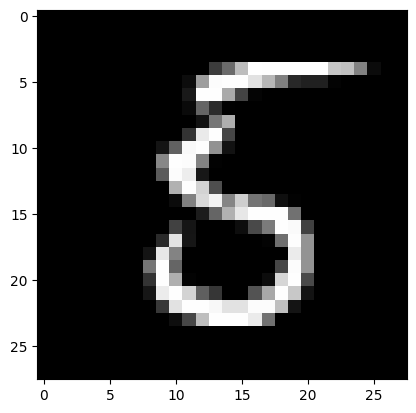

In [34]:
test_prediction(231, W1, b1, W2, b2)

In [35]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[8 9 0 2 6 1 1 5 1 9 5 7 6 2 6 9 1 2 2 4 1 0 2 9 6 9 1 4 7 3 3 8 2 3 7 5 9
 8 0 0 3 8 6 8 3 6 7 2 8 7 9 1 4 9 2 0 4 4 4 8 9 0 8 0 7 5 2 8 0 2 0 8 1 8
 0 8 9 6 7 2 5 9 6 6 2 9 9 2 7 0 0 3 2 3 4 1 1 9 1 5 0 4 7 0 2 7 8 7 4 7 9
 7 2 7 2 9 9 8 2 3 1 5 9 5 1 8 2 8 2 5 6 9 2 1 9 7 6 5 2 2 5 0 1 1 1 8 8 5
 7 5 5 8 6 7 0 6 6 4 1 3 1 2 6 1 5 1 6 6 4 1 7 1 3 0 0 6 7 1 9 7 2 3 1 2 4
 1 5 3 9 9 5 2 9 6 4 1 6 7 9 9 1 4 1 7 3 3 3 3 9 7 7 8 6 3 3 3 3 3 7 3 5 5
 2 1 5 7 6 1 9 5 9 9 2 4 6 3 1 6 2 5 0 5 9 3 4 8 7 8 3 6 5 1 8 3 9 5 6 1 7
 0 4 9 5 4 0 9 9 7 7 4 5 4 1 7 3 3 3 5 8 4 4 1 9 5 4 9 8 2 0 4 8 6 1 9 9 4
 1 7 9 7 3 2 7 4 6 3 3 4 0 3 7 5 4 9 9 4 9 0 2 0 7 5 9 4 6 0 7 8 8 0 6 4 5
 9 4 3 8 0 1 8 4 3 8 4 9 2 9 9 2 0 4 1 7 5 5 1 4 7 2 3 4 2 1 3 2 7 7 4 9 4
 9 9 7 7 8 9 9 3 1 3 2 4 8 0 7 7 0 0 4 1 3 4 2 4 5 2 8 8 3 8 4 3 9 1 9 0 5
 7 4 8 3 3 5 0 8 8 8 4 4 7 5 6 2 1 4 5 8 2 6 8 8 3 3 7 3 2 7 4 3 3 1 1 9 1
 5 3 0 2 3 7 2 3 5 7 6 3 5 2 5 4 5 5 5 4 1 1 8 4 3 2 5 6 6 4 0 9 9 5 5 1 1
 9 6 6 8 6 7 4 0 0 2 0 8 

np.float64(0.829)